In [106]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind, pearsonr # for testing relationships between cycling counts and weather variables
import os

# Various sklearn modules used in model creation and validation
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from weather_funcs import *
from processing import *
from analysis_funcs import *

pd.options.mode.chained_assignment = None

# Preprocessing

This uses the processing and weather functions to merge data files, extract then clean a sample of cycling data, add weather data to the sample, and run futher processing and feature engineering of weather data for analysis. This notebook starts with the statistical analysis itself.

In [ ]:
locations=pd.read_csv('Release notes/0-Count locations.csv')
# all_years_raw=get_all()
# all_years=get_hourly(process_data(all_years_raw))
# all_years.to_pickle('all_years.pkl')
all_years = pd.read_pickle('all_years.pkl')

# sample=build_sample(all_years)
# sample.to_pickle('sample.pkl')
sample=pd.read_pickle('sample.pkl')

# I made repeated calls to my 'add weather' function to avoid exceeding the API call limit. An example is below, not all are shown for brevity
add_weather(1, sample)

samples=os.listdir('samples')
data_untidied=pd.concat([pd.read_pickle('samples/' + file) for file in samples if file[-1]== 'l'], ignore_index=True)
data = prep_for_analysis(data_untidied)
morn_rush =data.loc[data.hour == 8]
eve_rush = data.loc[data.hour.isin([17,18])]

# Statistical analyses

Before building models, see if average cycling levels are higher in rainy weather using the qualitative descriptions, and look at correlations between cycling counts and continuous variables

In [87]:
clear_cloudy = morn_rush.loc[morn_rush.combined_descr.isin(['Clear', 'Clouds'])].Count
wet = morn_rush.loc[morn_rush.combined_descr.isin(['light rain/ drizzle', 'mod+heavy rain/ snow/ storm'])].Count
sig_test = ttest_ind(clear_cloudy, wet)
print(clear_cloudy.mean(), wet.mean())
print(sig_test)
corr_df = morn_rush[['wind_speed', 'rain_adj', 'tidied_clouds', 'temp', 'visibility_tidied', 'Count']].dropna()
corr_df['rain_cr'] = corr_df.rain_adj ** (1/3)
corrs = {}
for col in corr_df.columns[:-1]:
    corrs[col] = pearsonr(corr_df[col], corr_df.Count)
for item in corrs.items():
    print(item)

304.9391206313416 220.8
TtestResult(statistic=5.534518460209871, pvalue=3.2688660543504004e-08, df=5368.0)
('wind_speed', PearsonRResult(statistic=-0.02257150414297031, pvalue=0.09155059065106094))
('rain_adj', PearsonRResult(statistic=-0.07160208853938338, pvalue=8.385730982664271e-08))
('tidied_clouds', PearsonRResult(statistic=-0.046865388902911816, pvalue=0.000456983979034584))
('temp', PearsonRResult(statistic=0.009062276551416854, pvalue=0.49818095042281724))
('visibility_tidied', PearsonRResult(statistic=0.01742359053040563, pvalue=0.1927836410256056))
('Count', PearsonRResult(statistic=1.0, pvalue=0.0))


This difference is significant although correletaions find nothing , confirming what is expected from graphs

# Regression modelling

Start with the morning rush hour as there was more evidence of a relationship. Print the columns to remind us of the predictors

In [134]:
morn_rush.columns

Index(['Datetime', 'UnqID', 'Count', 'weath', 'sunrise', 'sunset', 'temp',
       'wind_speed', 'wind_deg', 'visibility', 'clouds', 'rain', 'main_descr',
       'detail_descr', 'darkness', 'tidied_clouds', 'visibility_tidied',
       'main_descr_adj', 'combined_descr', 'rain_adj', 'hour'],
      dtype='object')

Build a function that standardises predictors as recommended in a paper about feature engineering in weather (see report) and then set up a means of easily building a range of regression models without having to keep adding extra code - we can just confirm the data frame (i.e. could be morn_rush, or evening, or all), the predictors, the model and the categorical predictors so dummies can be added.

In [90]:
lasso = Lasso()
ridge = Ridge()
lin_reg = LinearRegression()

For analysis, it actually may be making things worse having the location which is such a big determinant, perhaps this should be removed.  Can see below an example output, although lots were tried - the cross validated r2 is low in all 5 runs.

In [91]:
do_regression(morn_rush, ['rain_adj', 'combined_descr'], lasso, ['combined_descr'])


array([ 0.00501868,  0.00998742,  0.00642436, -0.01386371,  0.00739659])

# Clustering

Experiment with clustering in case we can identify features associated with rain even if regression was inconclusive. The clustering algorithms in sklearn need continuous data so select those columns plus datetime and id as index so we can link back to original data if needed.

In [139]:
to_cluster = data[['UnqID', 'Datetime', 'temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied','Count', 'hour']]
to_cluster = to_cluster.set_index(['UnqID', 'Datetime'])

Start by removing visibility and dropping na from other rows, we can try to improve things by better use of visibility afterwards.  Try a range of values of k and get scores.

In [143]:
to_cluster = to_cluster.dropna()
norm = Normalizer()
to_cluster[to_cluster.columns] = norm.fit_transform(to_cluster)
scores = {}
for k in (list(range(2,11)) + list(range(12,22,2)) + list(range(25, 101, 5))):
    k_means = KMeans(n_clusters = k, n_init = 10)
    clusters = k_means.fit(to_cluster)
    labels = clusters.labels_
    scores[k] = silhouette_score(to_cluster, labels, metric='euclidean', sample_size = 10000)
scores




{2: 0.9845966647064542,
 3: 0.819708104823368,
 4: 0.8229081795397624,
 5: 0.7496852126764463,
 6: 0.6542509789292961,
 7: 0.6487109069567198,
 8: 0.594519936841162,
 9: 0.5403701906070855,
 10: 0.5261623830063646,
 12: 0.49053504456017083,
 14: 0.4213122230374589,
 16: 0.4364176215064784,
 18: 0.44193044886034877,
 20: 0.43402326039829847,
 25: 0.4206129589321494,
 30: 0.43724762559922603,
 35: 0.41877064712578077,
 40: 0.4299838484822279,
 45: 0.40046869732349943,
 50: 0.375911004150695,
 55: 0.387871263724717,
 60: 0.3634467756642476,
 65: 0.35124170849041875,
 70: 0.3683949837752425,
 75: 0.3631831178008269,
 80: 0.3597187000479284,
 85: 0.3619623043827338,
 90: 0.35347151077414773,
 95: 0.36655518119332675,
 100: 0.35432536632742895}

Helped by sklearn example we try mean-shift https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

In [144]:
bandwidth = estimate_bandwidth(to_cluster, n_samples = 10000, random_state = 142)
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms.fit(to_cluster)

ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 100


See how many are in each cluster - we can see even though there are 100 clusters, over 90% are in cluster 0 and 99% are in the top 3 clusters.

In [159]:
to_cluster['ms_clusters'] = ms_labels
pd.DataFrame({'count':to_cluster.ms_clusters.value_counts(),
                      'cumu percent':100*to_cluster.ms_clusters.value_counts().cumsum()/len(to_cluster)})


,count,cumu percent
ms_clusters,,
0,84945,94.371799
8,2258,96.880381
3,1745,98.819033
22,269,99.117886
1,127,99.258979
...,...,...
153,1,99.995556
187,1,99.996667
167,1,99.997778


Look at the profiles of the 3 most populous ones to see if they are informative - not clear with normalized data, would have been better to append clusters to pre-normalized data. However can see that count is much higher in cluster 8 and 3 than 0.

In [164]:
for clus in [0,8,3]:
    df = to_cluster.loc[to_cluster.ms_clusters == clus]
    print(clus, "\n", df.mean(), "\n")

0 
 temp                 0.001412
rain_adj             0.000013
wind_speed           0.000496
tidied_clouds        0.004714
visibility_tidied    0.999876
Count                0.009021
hour                 0.001421
ms_clusters          0.000000
dtype: float64 

8 
 temp                 0.001592
rain_adj             0.000017
wind_speed           0.000518
tidied_clouds        0.007254
visibility_tidied    0.997782
Count                0.065018
hour                 0.001594
ms_clusters          8.000000
dtype: float64 

3 
 temp                 0.001626
rain_adj             0.000014
wind_speed           0.000506
tidied_clouds        0.005870
visibility_tidied    0.994423
Count                0.103613
hour                 0.001538
ms_clusters          3.000000
dtype: float64 



Checking where these counts are shows it is busy central London locations which may explain why they have high counts but similar weather to cluster 0

In [170]:
site_check = pd.merge(to_cluster.loc[to_cluster.ms_clusters == 8].reset_index(level = ['UnqID']).UnqID.value_counts(), 
                      locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')
site_check

,count,Site ID,Location description
31,40,CENCY032,Borough High Street
51,36,CENCY052,Theobald's Road
86,34,CENCY088,Clerkenwell Road (east)
16,34,CENCY017,Waterloo Bridge
14,32,CENCY015,Millbank (north of Great Peter Street)
...,...,...,...
2283,1,SC14,London Bridge jw Cannon Street / Tooley Street
61,1,CENCY062,Charing Cross Road
465,1,CSHCY008,Wordworth Road
1954,1,QWPCY048,Southwark Bridge Road (south)


Experiment with first doing PCA for variables other than count - this would allow plotting in 3D space if clusters look useful

In [172]:
pca = PCA (n_components = 2)
X = to_cluster.drop(['Count'], axis = 1)
X_new = pca.fit_transform(X)
to_cluster[["comp_1", "comp_2"]] = X_new

ms_2 = MeanShift(bandwidth = bandwidth, bin_seeding = True)
ms_2.fit(to_cluster[['comp_1', 'comp_2', 'Count']])

ms_labels_2 = ms_2.labels_
cluster_centers_2 = ms_2.cluster_centers_

labels_unique_2 = np.unique(ms_labels_2)
n_clusters_2 = len(labels_unique_2)
score = silhouette_score(to_cluster[['comp_1', 'comp_2', 'Count']], ms_labels_2, metric='euclidean')
print("number of estimated clusters : %d" % n_clusters_2)
print(score)

number of estimated clusters : 213
0.9668376575273286


Check the spread of clusters again

In [173]:
to_cluster['ms_clusters_2'] = ms_labels_2
pd.DataFrame({'count':to_cluster.ms_clusters_2.value_counts(),
                      'cumu percent':100*to_cluster.ms_clusters_2.value_counts().cumsum()/len(to_cluster)})


,count,cumu percent
ms_clusters_2,,
0,84945,94.371799
1,2195,96.810390
2,1581,98.566842
3,261,98.856806
10,164,99.039006
...,...,...
98,1,99.995556
114,1,99.996667
79,1,99.997778


And the sites - look at clusters 1 and 2 as the biggest clusters outside the majority cluster 0 - same story

In [175]:
site_check_2 = pd.merge(to_cluster.loc[to_cluster.ms_clusters_2.isin([1,2])].reset_index(level = ['UnqID']).UnqID.value_counts(), 
                      locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')
site_check_2

,count,Site ID,Location description
16,68,CENCY017,Waterloo Bridge
31,65,CENCY032,Borough High Street
29,65,CENCY030,Blackfriars Bridge
30,63,CENCY031,London Bridge
14,63,CENCY015,Millbank (north of Great Peter Street)
...,...,...,...
111,1,CENCY113,Seymour Place
121,1,CENCY123,Cannon Street
1507,1,OUTCY052,Pinner Road
531,1,CSHCY074,Southwark Bridge Road (south)


Try k means again although expect to find similar

In [178]:
scores_2 = {}
for k in list(range(2,11)) + list(range(12,22,2)) + list(range(25, 101, 5)):
    k_means = KMeans(n_clusters = k, n_init = 10)
    k_clusters = k_means.fit(to_cluster[['comp_1', 'comp_2', 'Count']])
    k_labels = k_clusters.labels_
    scores_2[k] = silhouette_score(to_cluster[['comp_1', 'comp_2', 'Count']], k_labels, metric='euclidean', sample_size = 10000)
scores_2

{2: 0.9922764915724159,
 3: 0.9755595341367034,
 4: 0.975122879328513,
 5: 0.9754828439273647,
 6: 0.9764175772851402,
 7: 0.9756378101107901,
 8: 0.990456723739305,
 9: 0.9913313233040424,
 10: 0.9901389028083734,
 12: 0.9916239327589177,
 14: 0.9929873530995015,
 16: 0.9922295047011656,
 18: 0.9923531751450005,
 20: 0.9913035284293663,
 25: 0.9918721791098098,
 30: 0.9879358118142978,
 35: 0.9885576190615515,
 40: 0.9881463956996871,
 45: 0.988045512862941,
 50: 0.9887724309254536,
 55: 0.9879794051146804,
 60: 0.9880350344271633,
 65: 0.9882104720448924,
 70: 0.9881683681848171,
 75: 0.9883907044679301,
 80: 0.9888739074077244,
 85: 0.987592425317425,
 90: 0.9883251251391988,
 95: 0.9878309980770232,
 100: 0.9884256698098343}

Messed up by not having a way to link back to original data and de-normalize, resolve this later.  Try k means with 3 (as 2 has less than 1% in minority cluster) and transformed rain

In [182]:
# X_2 = to_cluster.drop([['hour','Count', 'comp_1', 'comp_2']], axis = 1)
to_cluster['rain_cr'] = to_cluster.rain_adj ** (1.3)
X_2 = to_cluster[['temp', 'rain_cr', 'wind_speed', 'tidied_clouds', 'hour']]
X_2_new = pca.fit_transform(X_2)
to_cluster[["comp_1_", "comp_2_"]] = X_2_new
to_cluster.head()

temp  rain_adj  wind_speed  tidied_clouds  \
UnqID Datetime                                                             
C03   2018-06-13 13:00:00  0.002062       0.0    0.000260       0.000000   
      2018-06-13 14:00:00  0.002061       0.0    0.000412       0.000000   
      2018-06-13 15:00:00  0.002111       0.0    0.000412       0.000000   
      2018-06-13 16:00:00  0.002090       0.0    0.000513       0.007492   
      2018-06-13 17:00:00  0.001994       0.0    0.000615       0.000000   

                           visibility_tidied     Count      hour  ms_clusters  \
UnqID Datetime                                                                  
C03   2018-06-13 13:00:00           0.999777  0.020995  0.001300            0   
      2018-06-13 14:00:00           0.999757  0.021895  0.001400            0   
      2018-06-13 15:00:00           0.999630  0.027090  0.001499            0   
      2018-06-13 16:00:00           0.998997  0.044056  0.001598            0   
      2018-06-13 17:00:00           0.991190  0.132423  0.001685            3   

                             comp_1    comp_2  ms_clusters_2  ms_cluster  \
UnqID Datetime                                                             
C03   2018-06-13 13:00:00 -0.921779 -0.002250              0           0   
      2018-06-13 14:00:00 -0.921779 -0.002217              0           0   
      2018-06-13 15:00:00 -0.921778 -0.002068              0           0   
      2018-06-13 16:00:00 -0.921735  0.005554              0           0   
      2018-06-13 17:00:00  3.320841 -0.019626              2           2   

                           cluster  rain_cr   comp_1_   comp_2_  
UnqID Datetime                                                   
C03   2018-06-13 13:00:00        0      0.0 -0.006256  0.000944  
      2018-06-13 14:00:00        0      0.0 -0.006243  0.001034  
      2018-06-13 15:00:00        0      0.0 -0.006230  0.001133  
      2018-06-13 16:00:00        0      0.0  0.001210  0.000241  
      2018-06-13 17:00:00        0      0.0 -0.006218  0.001197

In [185]:
two_clus = KMeans(n_clusters = 3, n_init = 10)
two_clus.fit(to_cluster[['comp_1_', 'comp_2_', 'Count']])
tc_labels = two_clus.labels_
to_cluster['k_cluster'] = tc_labels
to_cluster.k_cluster.value_counts()

k_cluster
1    85677
0     4181
2      153
Name: count, dtype: int64

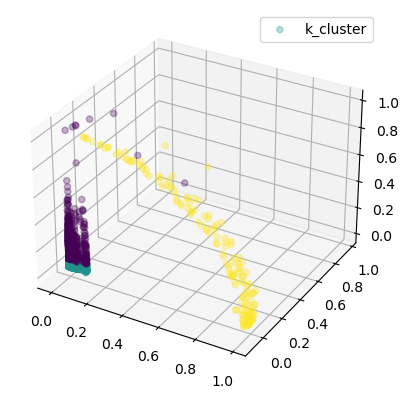

In [186]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data = to_cluster, xs = 'comp_1_', ys = 'comp_2_', zs = 'Count', c = 'k_cluster', alpha = 0.3, label = 'k_cluster')
ax.legend()

Earlier analysis found more interesting relationships focusing on the morning rush hour so try that with clustering.  Drop na before standardising then add the clusters back to the original data i.e. so the means we get of clusters are not standardised and make more sense. Try both 2 and 3 as these seem to be most sensible

In [187]:
morn_cont = morn_rush[['UnqID', 'Datetime', 'temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied','Count']]
morn_cont = morn_cont.set_index(['UnqID', 'Datetime'])
morn_cont = morn_cont.dropna()

morn_cont_std = standardise(morn_cont, morn_cont.columns)
morn_cont_std = morn_cont_std.drop(['wind_speeed'], axis = 1)

pca = PCA(n_components = 2)
comps =  pca.fit_transform(morn_cont_std[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
morn_cont_std[["comp_1", "comp_2"]] = comps



In [188]:
two_clus = KMeans(n_clusters = 2, n_init = 10)
two_clus.fit(morn_cont_std[['comp_1', 'comp_2', 'Count']])
tc_labels = two_clus.labels_
morn_cont['cluster'] = tc_labels
morn_cont.cluster.value_counts()

cluster
0    4923
1     666
Name: count, dtype: int64

In [191]:
three_clus = KMeans(n_clusters = 3, n_init = 10)
three_clus.fit(morn_cont_std[['comp_1', 'comp_2', 'Count']])
thrc_labels = three_clus.labels_
morn_cont['three_cluster'] = thrc_labels
morn_cont.three_cluster.value_counts()

three_cluster
1    4414
0    1014
2     161
Name: count, dtype: int64

Check the sites again, same issue

In [197]:
site_check_3 = pd.merge(morn_cont.loc[(morn_cont.cluster ==1) | (morn_cont.three_cluster.isin([0,2]))].UnqID.value_counts(), 
    locations[['Site ID', 'Location description']], left_index = True, right_on = 'Site ID')

site_check_3

,count,Site ID,Location description
6,19,CENCY007,Albert Embankment (south of Salamanca Street)
14,18,CENCY015,Millbank (north of Great Peter Street)
65,17,CENCY066,Farringdon Road (near station)
16,17,CENCY017,Waterloo Bridge
0,16,CENCY001,Millbank (south of Thorney Street)
...,...,...,...
353,1,CGRCY111,Appold Street
354,1,CGRCY112,Aldgate High Street
264,1,CGRCY022,Crawford Street (east)
278,1,CGRCY036,New Bond Street


What if we focus on the busiest sites so the location doesn't dominate

In [201]:
total_count_per_site = pd.DataFrame(
    data.groupby(['UnqID']).Count.sum().sort_values(ascending = False))
busiest_sites = pd.merge(total_count_per_site[:10], locations['Location description'], left_index = True, right_index = True)
busiest_sites

,Count,Location description
UnqID,,
CENCY015,111956.0,Millbank (north of Great Peter Street)
CENCY017,113131.0,Waterloo Bridge
CENCY029,137882.0,Temple
CENCY030,151748.0,Blackfriars Bridge
CENCY031,117420.0,London Bridge
CENCY032,114062.0,Borough High Street
CENCY039,130140.0,Gracechurch Street
CENCY044,145917.0,New Bridge Street
CENCY052,110552.0,Theobald's Road


Before clustering on this data, look at some more basic stats. Focus on morning rush hour and look at qual descriptions - higher counts in better weather although sample sizes are very small

combined_descr
Clouds                         92
Clear                          54
light rain/ drizzle            19
Haze                            7
mod+heavy rain/ snow/ storm     2
Mist                            1
Name: count, dtype: int64

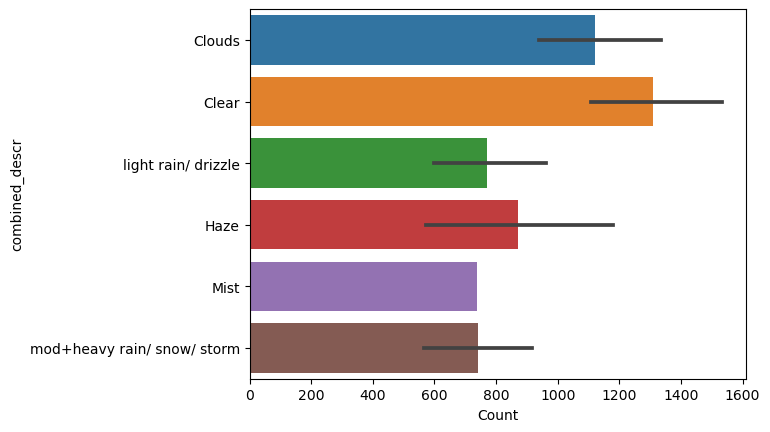

In [204]:
busiest_sites_morn_rush= data.loc[(data.UnqID.isin(busiest_sites.index)) & (data.hour ==8)]
sns.barplot(data = busiest_sites_morn_rush, y = 'combined_descr', x = 'Count')
busiest_sites_morn_rush.combined_descr.value_counts()

Look at darkness - can see  that for all sites it doesn't tell us a great deal when looking by temperature or rain

<Axes: xlabel='temp', ylabel='Count'>

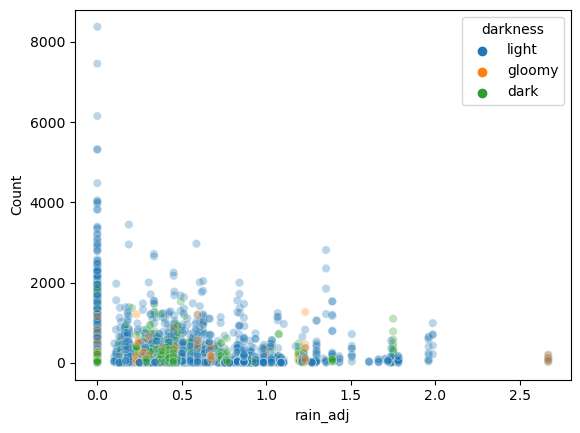

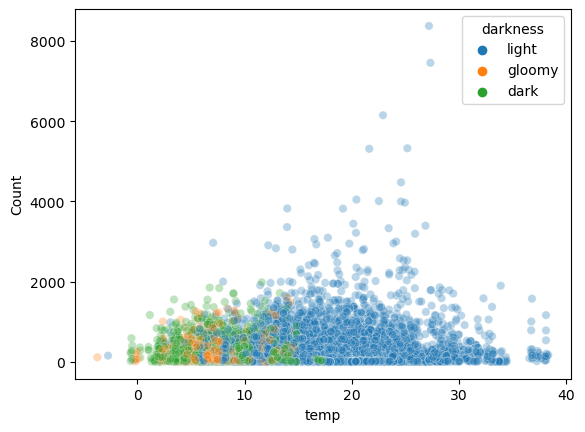

In [206]:
plt.figure()
sns.scatterplot(data = eve_rush, x = 'rain_adj', y = 'Count', hue ='darkness', alpha = 0.3)
plt.figure()
sns.scatterplot(data = eve_rush, x = 'temp', y = 'Count', hue ='darkness', alpha = 0.3)

But what if we focus on the busiest sites - the scatter plots don't show much again (i.e. when looking at other variables) but focusing on darkness alone we can see there are more cycle journeys in the light in evening rush hour

darkness
dark       773.619048
gloomy     718.609756
light     1047.135922
Name: Count, dtype: float64
darkness
dark       773.619048
gloomy     718.609756
light     1047.135922
Name: Count, dtype: float64


[Text(0.5, 0, 'Darkness'), Text(0, 0.5, 'Average cycle count per site')]

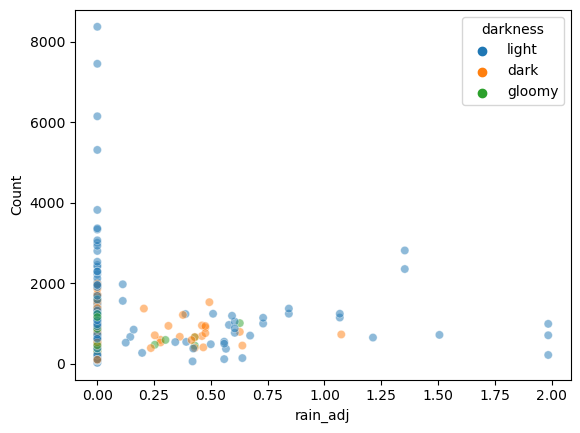

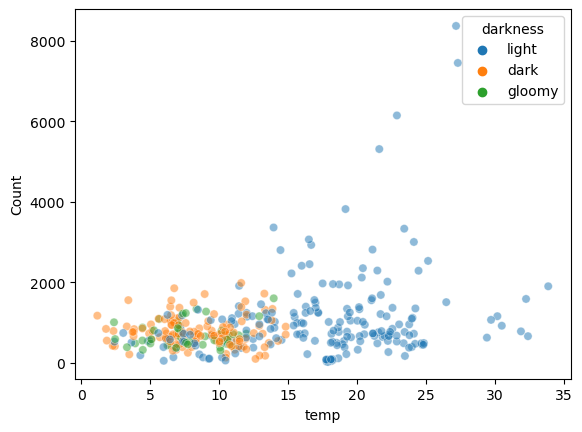

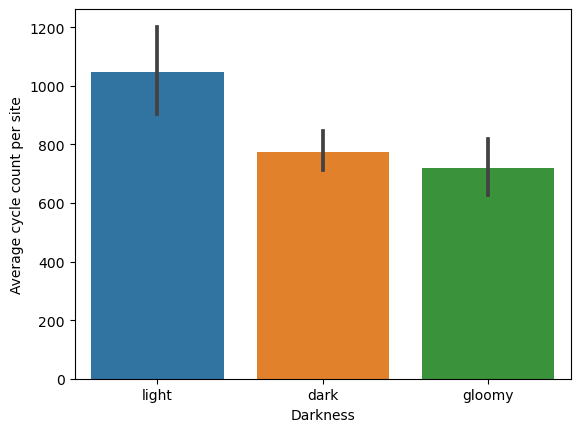

In [209]:
busiest_sites_eve_rush = eve_rush.loc[eve_rush.UnqID.isin(busiest_sites.index)]

plt.figure()
sns.scatterplot(data = busiest_sites_eve_rush, x = 'rain_adj', y = 'Count', hue ='darkness', alpha = 0.5)
plt.figure()
sns.scatterplot(data = busiest_sites_eve_rush, x = 'temp', y = 'Count', hue ='darkness', alpha = 0.5)
print(busiest_sites_eve_rush.groupby('darkness').Count.mean())
print(busiest_sites_eve_rush.groupby('darkness').Count.mean())
plt.figure()
sns.barplot(data = busiest_sites_eve_rush, x = 'darkness', y = 'Count').set(
    xlabel = 'Darkness', ylabel = 'Average cycle count per site')

Try and cluster this data but the minority cluster only contains 12 records, not very helpful

In [210]:
busiest_sites_er_for_clus = standardise(
    busiest_sites_eve_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']].dropna(), 
    [['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busy_comps =  pca.fit_transform(
    busiest_sites_er_for_clus[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busiest_sites_er_for_clus[["comp_1", "comp_2"]] = busy_comps
for i in range(2,11):
    busy_clus = KMeans(n_clusters = i, n_init = 10)
    busy_clus.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
    bc_labels = busy_clus.labels_
    busiest_sites_er_for_clus['cluster'] = bc_labels
    score = silhouette_score(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']],bc_labels, metric='euclidean')
    print(i, "Score=", score)




2 Score= 0.7616803699299945
3 Score= 0.8112530087881323
4 Score= 0.6226058800752047
5 Score= 0.542399737486345
6 Score= 0.546120601553432
7 Score= 0.483908173102238
8 Score= 0.50144595565855
9 Score= 0.49058438045204583
10 Score= 0.5068781443058801


Set up model with k = 3

In [211]:
busy_clus = KMeans(n_clusters = 3, n_init = 10)
busy_clus.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
bc_labels = busy_clus.labels_
busiest_sites_er_for_clus['cluster'] = bc_labels
busiest_sites_er_for_clus.cluster.value_counts()


cluster
0    337
1     17
2      7
Name: count, dtype: int64

In [217]:
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster == 0].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster.isin([1,2])].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())

temp                   12.871691
rain_adj                0.103561
wind_speed              4.988487
tidied_clouds          38.842730
visibility_tidied    9985.163205
Count                 779.106825
dtype: float64
temp                   18.280000
rain_adj                0.136077
wind_speed              5.188750
tidied_clouds          60.416667
visibility_tidied    8750.000000
Count                2865.750000
dtype: float64


Suggests higher cycling counts in morning rush hour at higher temperatures although very small sample size, with the majority cluster dominating, and rainfall is actually higher

and 2 as a check

In [213]:
busy_clus_ = KMeans(n_clusters = 2, n_init = 10)
busy_clus_.fit(busiest_sites_er_for_clus[['comp_1', 'comp_2', 'Count']])
bc_labels_ = busy_clus_.labels_
busiest_sites_er_for_clus['cluster_2'] = bc_labels_
busiest_sites_er_for_clus.cluster_2.value_counts()


cluster_2
0    344
1     17
Name: count, dtype: int64

Look at the means again -  similar story with repsect to temperature, a bigger difference for rainfall. Clearly higher rainfall isn't going to mean 5* as many people cycle therefore this clustering is of limited value.

In [218]:
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster_2 == 0].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())
print(busiest_sites_er_for_clus.loc[busiest_sites_er_for_clus.cluster_2 == 1].drop(
    ['comp_1', 'comp_2', 'cluster', 'cluster_2'], axis = 1).mean())

temp                   12.849709
rain_adj                0.103078
wind_speed              4.967791
tidied_clouds          39.418605
visibility_tidied    9898.255814
Count                 776.337209
dtype: float64
temp                    20.951765
rain_adj                 0.159251
wind_speed               5.690000
tidied_clouds           57.647059
visibility_tidied    10000.000000
Count                 3781.000000
dtype: float64


In [219]:
busiest_sites_mr_for_clus = standardise(busiest_sites_morn_rush[[
    'temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']].dropna(), 
    [['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busy_morn_comps =  pca.fit_transform(
    busiest_sites_mr_for_clus[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied']])
busiest_sites_mr_for_clus[["comp_1", "comp_2"]] = busy_morn_comps

busy_morn_clus = KMeans(n_clusters = 2, n_init = 10)
busy_morn_clus.fit(busiest_sites_mr_for_clus[['comp_1', 'comp_2', 'Count']])
bc_morn_labels = busy_morn_clus.labels_
busiest_sites_mr_for_clus['cluster'] = bc_morn_labels
busiest_sites_mr_for_clus.cluster.value_counts()
print(busiest_sites_mr_for_clus.loc[busiest_sites_mr_for_clus.cluster == 0].mean(), "\n")
print(busiest_sites_mr_for_clus.loc[busiest_sites_mr_for_clus.cluster == 1].mean())


temp                   10.316809
rain_adj                0.063030
wind_speed              4.279078
tidied_clouds          51.382979
visibility_tidied    9829.787234
Count                1158.234043
comp_1               -681.638401
comp_2                 -1.028214
cluster                 0.000000
dtype: float64 

temp                    7.984762
rain_adj                0.080222
wind_speed              2.922381
tidied_clouds          52.142857
visibility_tidied    4571.428571
Count                 979.000000
comp_1               4576.714979
comp_2                  6.903720
cluster                 1.000000
dtype: float64


Now try morning rush hour. 2 clusters doesn't help much initially as counts are similar, so try and cluster all variables rather than using PCA. To do this, create a separate dataframe of continuous variables that can be standardised then put clusters into original morning rush hour df once done (after first establishing k = 2 is best)

In [220]:
for i in range(2,11):
    df = busiest_sites_morn_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']] .dropna()
    busy_morn_clus_2 = KMeans(n_clusters = i, n_init = 10)
    busy_morn_clus_2.fit(df)
    bc_morn_2_labels = busy_morn_clus_2.labels_
    score = silhouette_score(df, bc_morn_2_labels)
    print(i, "Score=", score)

busy_morn_clus_df = busiest_sites_morn_rush[['temp', 'rain_adj', 'wind_speed', 'tidied_clouds', 'visibility_tidied', 'Count']] .dropna()
busy_morn_clus_std = busy_morn_clus_df.copy() 
busy_morn_clus_std = standardise(busy_morn_clus_std, busy_morn_clus_std.columns)
busy_morn_clus_2 = KMeans(n_clusters = 2, n_init = 10)
busy_morn_clus_2.fit(busy_morn_clus_std)
bc_morn_2_labels = busy_morn_clus_2.labels_
busy_morn_clus_df['cluster'] = bc_morn_2_labels
busy_morn_clus_df['rain'] = busy_morn_clus_df.rain_adj ** 3

2 Score= 0.7697975523229285
3 Score= 0.5259399264978327
4 Score= 0.5563819132088812
5 Score= 0.5457791555706052
6 Score= 0.5527985164302983
7 Score= 0.48123390791193804
8 Score= 0.4817820255524544
9 Score= 0.49614151936430967
10 Score= 0.5018450218801607
cluster sizes 118 44


Check the cluster sizes and means - looks to be some slight differences with higher temps and lower rain associated with higher counts in cluster 1, although sample sizes are very small. 

In [222]:
busy_morn_clus_0 = busy_morn_clus_df.loc[busy_morn_clus_df.cluster == 0]
busy_morn_clus_1 = busy_morn_clus_df.loc[busy_morn_clus_df.cluster == 1]
print("cluster sizes", len(busy_morn_clus_0), len(busy_morn_clus_1))
print("cluster 0 means", "\n", busy_morn_clus_0.mean(), "\n\n", "cluster 1 means", "\n", busy_morn_clus_1.mean())
print(len(busy_morn_clus_df.loc[busy_morn_clus_df.rain_adj > 0]))
print(len(busy_morn_clus_0.loc[busy_morn_clus_0.rain_adj >0] ))
print(len(busy_morn_clus_1.loc[busy_morn_clus_1.rain_adj >0] ))

cluster sizes 118 44
cluster 0 means 
 temp                    9.540169
rain_adj                0.085553
wind_speed              4.053559
tidied_clouds          53.050847
visibility_tidied    9050.847458
Count                 761.398305
cluster                 0.000000
rain                    0.093891
dtype: float64 

 cluster 1 means 
 temp                   11.286591
rain_adj                0.010833
wind_speed              4.236364
tidied_clouds          47.272727
visibility_tidied    9409.090909
Count                2136.931818
cluster                 1.000000
rain                    0.000930
dtype: float64
21
19
2


Show these differences on a graph and check means are sig - pvalues of 0.06 i.e. would be significant at 10% level but not 5%

/var/folders/mn/vlrzh77x3js88tqj0c63hvbr0000gn/T/ipykernel_31991/2591178363.py:10: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


TtestResult(statistic=-1.877918305004132, pvalue=0.06221203280893015, df=160.0)
TtestResult(statistic=1.8619051562276459, pvalue=0.06445055912038605, df=160.0)


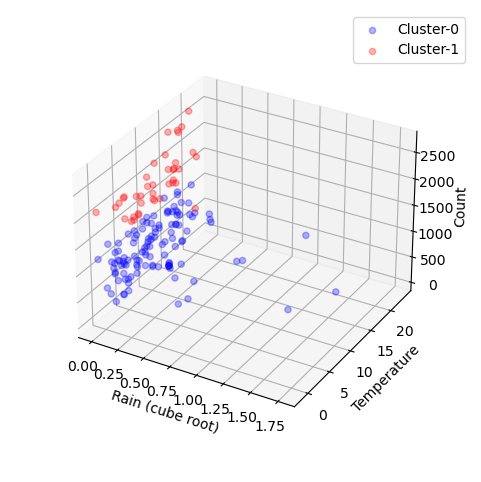

In [224]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')

scat_0 = ax.scatter(data = busy_morn_clus_0.loc[busy_morn_clus_0.Count< 2700], xs = 'rain_adj', ys = 'temp', zs = 'Count', c = 'blue',
           alpha = 0.3)
scat_1 = ax.scatter(data = busy_morn_clus_1.loc[busy_morn_clus_1.Count< 2700], xs = 'rain_adj', ys = 'temp', zs = 'Count', c = 'red',
           alpha = 0.3)
ax.set(xlabel = 'Rain (cube root)', ylabel = 'Temperature', zlabel = 'Count')
ax.legend([scat_0, scat_1], ["Cluster-0", "Cluster-1"])
ax.dist = 12

test_temp = ttest_ind(busy_morn_clus_0.temp, busy_morn_clus_1.temp)
test_rain = ttest_ind(busy_morn_clus_0.rain_adj, busy_morn_clus_1.rain_adj)
print(test_temp)
print(test_rain)